In [1]:
import blob_class as bc
import math
import numpy as np
import cv2 as cv
%matplotlib inline
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max
from scipy.stats import zscore
from skimage.segmentation import watershed
from scipy import ndimage as ndi

In [2]:
def flatten(L, flat_list=None):

    # initialize flat list on first call
    if flat_list is None:
        flat_list = []

    for val in L:
        # if inner list, call flatten
        if isinstance(val, list):
            flatten(val, flat_list)

        # if not inner list, append value
        else:
            flat_list.append(val)

    return flat_list

In [3]:
def blob_im(im, blobs):

    blobs_flat = flatten(blobs)  # flatten nested list

    im_copy = im.copy()  # create copy of image to return
    contours = [blob.cv_contour for blob in blobs_flat]

    # draw contours on the copied image
    cv.drawContours(im_copy, contours, -1, (0, 255, 0), 2, cv.LINE_8)

    return im_copy

In [4]:
def get_maxima(image, distance=20, threshold=0.8):
    
    if isinstance(image, np.ndarray):
        if image.ndim > 2:
            image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

        local_max_thresh = np.mean(image) * threshold
        local_max_coords = peak_local_max(image,
                                          min_distance=distance,
                                          threshold_abs=local_max_thresh)
        local_max_coords = [[x, y] for y, x in local_max_coords]  # switch to x,y
        return local_max_coords
    
    elif isinstance(image, bc.Blob):
        local_max_thresh = image.pixel_intensity_percentile(threshold * 100)
        local_max_coords = peak_local_max(image.image_masked,
                                          min_distance=distance,
                                          threshold_abs=local_max_thresh)
        local_max_coords = [[x, y] for y, x in local_max_coords]  # switch to x,y
        return local_max_coords
    
    else:
        raise TypeError('image must be numpy array or Blob instance')

In [5]:
def get_contours(image, thresh_min, thresh_max=255, thresh_step=10):
    im_thresh = [cv.threshold(image, i, 255, cv.THRESH_BINARY)[1]
                 for i in range(thresh_min, thresh_max, thresh_step)]
    
    contours_nested = [cv.findContours(thresh,
                                       cv.RETR_EXTERNAL,
                                       cv.CHAIN_APPROX_NONE)[0]
                       for thresh in im_thresh]
    
    contours = [contour for contours in contours_nested
                        for contour in contours]
    return contours


In [11]:
def segment_contours(binary_image):
    # apply distance transform
    distance = ndi.distance_transform_edt(binary_image)
    
    # find maximum coordinates and label on mask
    coords = peak_local_max(distance, min_distance=10, footprint=np.ones((3, 3)), labels=binary_image)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    
    # perform watershed segmentation
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=binary_image)
    
    # get contours of labeled points
    contours = []
    for i in range(1, np.max(labels)+1):
        binary = np.zeros(labels.shape, dtype="uint8")
        binary[np.where(labels==i)] = 255
        contour, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
        contours.append(contour[0])
        
    return contours

In [6]:
def maxima_filter(contour, local_maxima):
    points = np.array([cv.pointPolygonTest(np.array(contour),
                                  (int(maxima[0]), int(maxima[1])),
                                  False)
                       for maxima in local_maxima])

    if np.sum(points==True) >= 1:  # if maxima found
        idxs = np.where(points==True)
        maxima = np.array(local_maxima)[idxs]
        return maxima, idxs[0]

    # return None if no maxima found
    return None, None

In [7]:
def blob_filter(blob, filters):
    for filt in filters:

        if filt[1]:
            if not (eval('blob.' + filt[0]) >= filt[1]):
                return False

        if filt[2]:
            if not (eval('blob.' + filt[0]) <= filt[2]):
                return False

    return True

In [8]:
def similar_filter(blob_list, params, num=2):
    # First check that blob_list is long enough to analyze
    if len(blob_list) >= num:
        sim_list = [[]]
        sim_idx = 0
        last_blob = None

        for blob in blob_list:
            if last_blob is not None:  # if not the first blob in list
                filters = []

                # Create filters to be passed into blob_filter()
                # Filters are based on previous blob in blob_list
                # and used to determine if the current blob is
                # similar enough to the previous blob
                for i in range(len(params)):
                    val = eval('last_blob.' + params[i][0])
                    val_range = val * params[i][1]
                    val_min = val - val_range
                    val_max = val + val_range
                    filters.append([params[i][0], val_min, val_max])

                # check if current blob is similar to previous blob
                # and add nested list to sim_list if NOT similar
                if not blob_filter(blob, filters):
                    sim_list.append([])
                    sim_idx += 1

            # Append blob to appropiate location in sim_list
            # Same list as previous blob if similar
            # New inner list if NOT similar
            sim_list[sim_idx].append(blob)
            last_blob = blob

        # Get the nested list of similar blobs with highest number of blobs
        sim_len = [len(sim) for sim in sim_list]
        sim_max_idx = [idx for idx, item in enumerate(sim_len)
                       if item == max(sim_len)]
        sim_blobs = sim_list[sim_max_idx[0]]  # returns first index if tie

        # Final check that similar blobs are above the required number
        if len(sim_blobs) >= num:
            return sim_blobs

    # Return None if not enough similar blobs are found
    return None

In [9]:
def outlier_filter(blob_list, params):
    # create copy of list as numpy array
    blob_copy = np.array(blob_list.copy())

    for param in params:
        vals = [eval('blob.' + param[0]) for blob in blob_copy]
        zscores = np.array(zscore(vals))  # calculate zscores for param
        mean = np.mean(vals)  # calculate mean of param

        # Calculate safe zone (not outlier) if blob is within a specified
        # percentage of the mean of the blobs
        safe = [mean - (mean * param[1]), mean + (mean * param[1])]

        # Remove outliers if blob not within safe zone or specified zscore
        out_coords = np.where(((zscores >= -param[2]) & (zscores <= param[2]))
                              | ((vals >= safe[0]) & (vals <= safe[1])))
        blob_copy = blob_copy[out_coords]

    return list(blob_copy)

In [10]:
def blob_best(blob_list, criteria):
    # initial score of 0 for each blob
    score = np.zeros(len(blob_list))

    for crit in criteria:
        # get blob values for the criteria
        vals = np.array([eval('blob.' + crit[0]) for blob in blob_list])

        # vals_unique is a list of unique values in vals
        # rank is how well blob fits criteria (highest score = closest)
        # rank is automatically sorted low -> high so needs to be
        # reversed in 'min' and ideal value conditions (ex. [1,0,2] -> [1,2,0])
        if crit[1] == 'min':
            vals_unique, rank = np.unique(vals, return_inverse=True)
            rank = abs(rank-(len(vals_unique)-1))

        elif crit[1] == 'max':
            vals_unique, rank = np.unique(vals, return_inverse=True)

        elif type(crit[1]) == int or type(crit[1]) == float:
            diff = abs(vals - crit[1])
            vals_unique, rank = np.unique(diff, return_inverse=True)
            rank = abs(rank-(len(vals_unique)-1))

        rank = np.multiply(rank, crit[2])  # multiple rank by factor
        score = np.add(score, rank)  # add rank to overall score

    # Find idx of blob with highest score
    max_score = max(score)
    max_idx = list(score).index(max_score)

    # Return highest scoring blob
    return blob_list[max_idx]

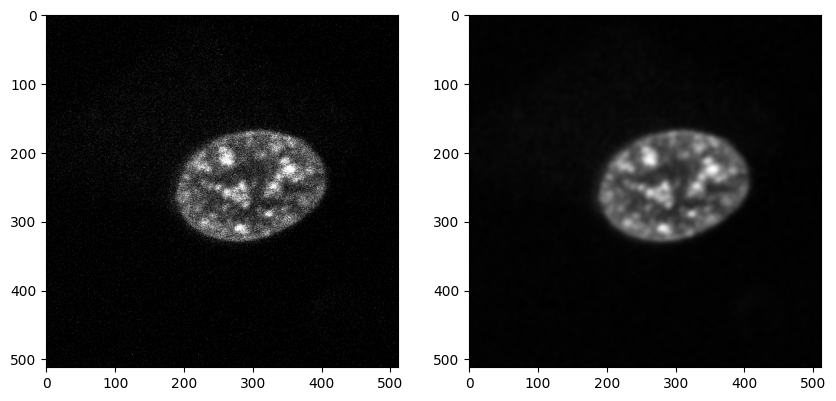

In [13]:
im = cv.imread('ex6.tif')
im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
im_blur = cv.GaussianBlur(im_gray,(15,15),0)

ret, im_binary = cv.threshold(im_blur, 25, 255, cv.THRESH_BINARY)
contours, hierarchy = cv.findContours(im_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
contour = max(contours, key=cv.contourArea)
blob_blur = bc.Blob(contour, im_blur)

fig = plt.figure(figsize = (10,7))
fig.add_subplot(1, 2, 1)
plt.imshow(im, cmap = "gray")
fig.add_subplot(1, 2, 2)
plt.imshow(im_blur, cmap = "gray")
plt.show()

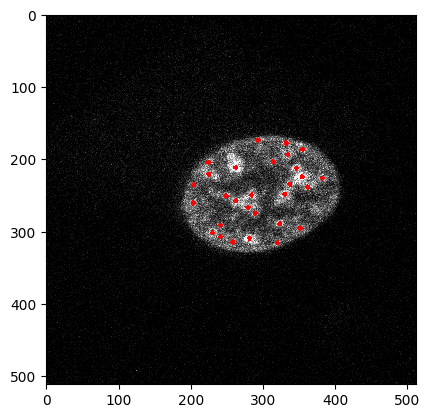

In [20]:
# local_max_thresh = blob_blur.pixel_intensity_percentile(80)
# local_max_coords = peak_local_max(blob_blur.image_masked, min_distance=20, threshold_abs=local_max_thresh)
# local_max_coords = [[x, y] for y, x in local_max_coords]  # switch to x,y
local_max_coords = get_maxima(blob_blur, 4, 0.85)
im_maxima = im.copy()

for coordinate in local_max_coords:
    cv.circle(im_maxima, (coordinate), 2, (255,0,0), 2)
plt.imshow(im_maxima, interpolation='nearest')
plt.show()

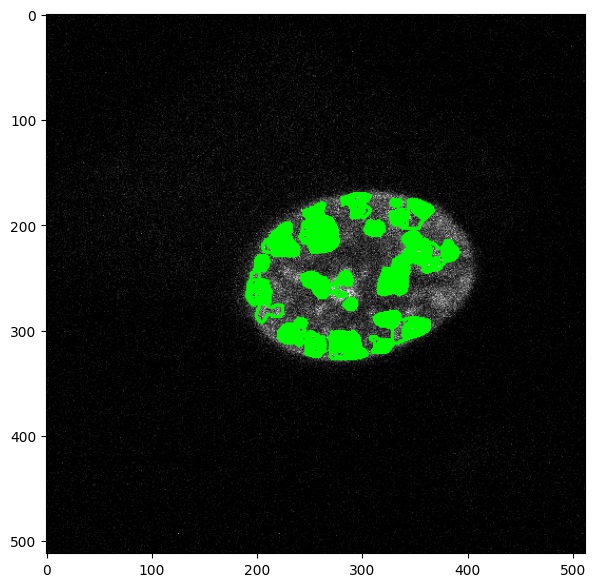

In [21]:
min_thresh = int(blob_blur.pixel_intensity_median)
contours = get_contours(im_blur, min_thresh)

contour_list = [[] for i in range(len(local_max_coords))]
if len(contours) > 0:
    for contour in contours:
        keys, key_idxs = maxima_filter(contour, local_max_coords)
        if keys is not None:
            if len(keys) == 1:
                contour_list[key_idxs[0]].append(bc.Blob(contour, im))
                
            else: # if len(keys) > 1
                seg_binary = np.zeros(im_gray.shape, dtype="uint8")
                cv.fillPoly(seg_binary, pts=[contour], color=(255,255,255))
                seg_contours = segment_contours(seg_binary)
                for sc in seg_contours:
                    keys, key_idxs = maxima_filter(sc, local_max_coords)
                    if keys is not None:
                        if len(keys) == 1:
                            contour_list[key_idxs[0]].append(bc.Blob(sc, im))

plt.figure(figsize=(14,7))
plt.imshow(blob_im(im, contour_list))
plt.show()

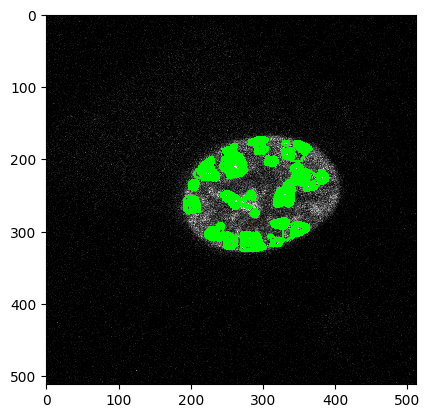

In [22]:
filters = [['area', 25, None], # at least 0.05% of nucleus area
           ['ellipse_fit_residual_mean', None, 2]]      

blob_list = []
for contours in contour_list:
    blob_list.append([x for x in contours if blob_filter(x, filters)])
plt.imshow(blob_im(im, blob_list), interpolation='nearest')
plt.show()

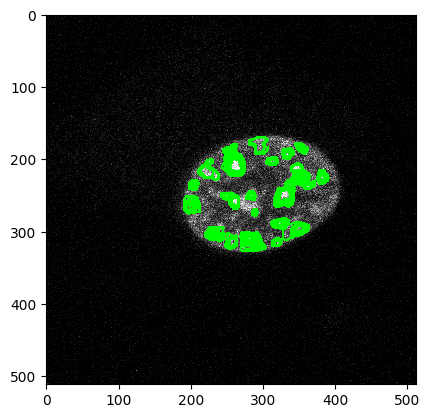

In [23]:
params = [['aspect_ratio', 0.2],
          ['solidity', 0.1],
          ['roughness_perimeter', 0.1],
          ['circularity', 0.2]]

sim_blobs = [similar_filter(blobs, params, 2) for blobs in blob_list]
sim_blobs = [blobs for blobs in sim_blobs if blobs is not None]

plt.imshow(blob_im(im, sim_blobs), interpolation='nearest')
plt.show()

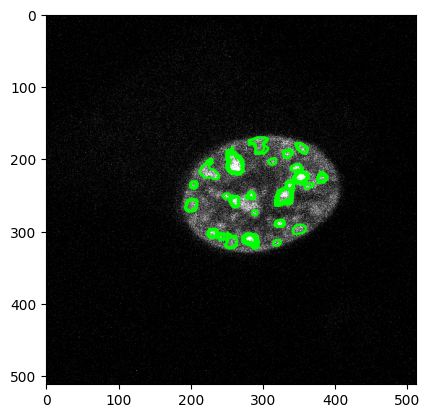

In [24]:
out_filter = [['curvature_mean()', 0.1, 1],
              ['perimeter_crofton', 0.2, 1]]
no_outs = [outlier_filter(blobs, out_filter) for blobs in sim_blobs] 

plt.imshow(blob_im(im, no_outs))
plt.show()

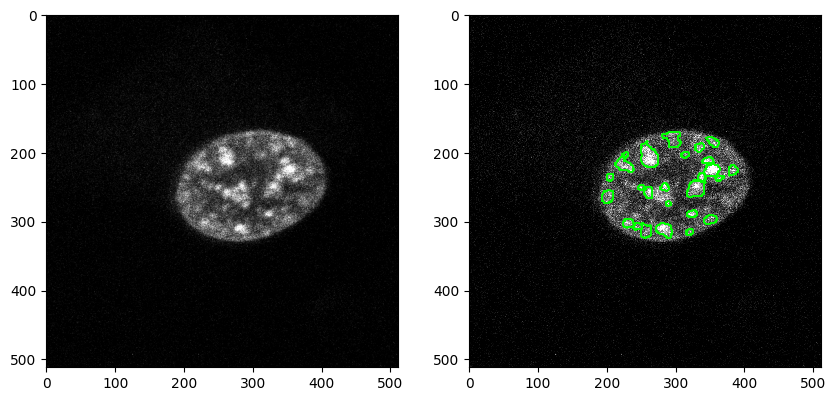

In [25]:
criteria = [['area_filled', 'max', 1],
            ['roughness_surface', 'min', 1]]
blobs_best = [blob_best(blobs, criteria) for blobs in no_outs]

fig = plt.figure(figsize = (10,7))
fig.add_subplot(1, 2, 1)
plt.imshow(im)
fig.add_subplot(1, 2, 2)
plt.imshow(blob_im(im, blobs_best), interpolation='nearest')
plt.show()